In [1]:
#This project uses Sean Lahman's Baseball Database, which is accessible at https://sabr.org/lahman-database/
#The data is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License. For details see http://creativecommons.org/licenses/by-sa/3.0/

import pandas as pd
from numpy import NaN
from numpy.polynomial.polynomial import polyfit
from sklearn import linear_model, metrics, model_selection
from matplotlib import pyplot as plt

#read in csv with stats
df_stats = pd.read_csv('data/Pitching.csv')
#Older entries don't have BAOpp, IBB, SH, SF, GIDP, so fills these stats in as 0 if not present
df_stats[['BAOpp', 'IBB', 'SH', 'SF', 'GIDP']] = df_stats[['BAOpp', 'IBB', 'SH', 'SF', 'GIDP']].fillna(0)
#function that finds the ERA that a pitcher pitched the year after the year of the row given, fills with NaN if does not exist
def find_next_year_era(row, df):
    to_return = df.loc[(df['playerID'] == row['playerID']) & (df['yearID'] == row['yearID'] + 1)]
    if to_return.empty:
        return NaN
    else:
        new_value = to_return.ERA
        return new_value.iloc[0]

#create dataframe from 1993 onward to train stats on, older data is more inconsistent
recent_data = df_stats[df_stats.yearID.between(1993, 2022)]
#Train data on starters who will have more consistent numbers
recent_data = recent_data[recent_data.GS > 10]
#Add ERA from next season pitched, if it exists
recent_data['newERA'] = recent_data.apply(find_next_year_era, axis=1, args=(recent_data,))
#remove any seasons that don't have a future season to train off of
recent_data = recent_data.dropna()
#remove irrelevant info like name and team
x = recent_data.drop(recent_data.columns[0:5], axis=1)
#remove new ERA that will be used to evaluate
x = x.drop(recent_data.columns[30], axis=1)
y = recent_data[recent_data.columns[30]]
#split into training and testing data
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3)
#Create and train linear regression
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
model_pred = model.predict(x_test)

#prints r squared value for the linear regression model, mean squared error for linear regression model, and the r squared value for predicting ERA will not change in the future season
print('linear r-squared:', metrics.r2_score(y_test, model_pred))
print('linear MSE:', metrics.mean_squared_error(y_test, model_pred))
print('ERA season prior:', metrics.r2_score(recent_data.newERA, recent_data.ERA))
print('ERA season prior MSE:', metrics.mean_squared_error(recent_data.newERA, recent_data.ERA))

linear r-squared: 0.18210520221344972
linear MSE: 0.9309961368095335
ERA season prior: -0.2938137870661337
ERA season prior MSE: 1.5790873180873182


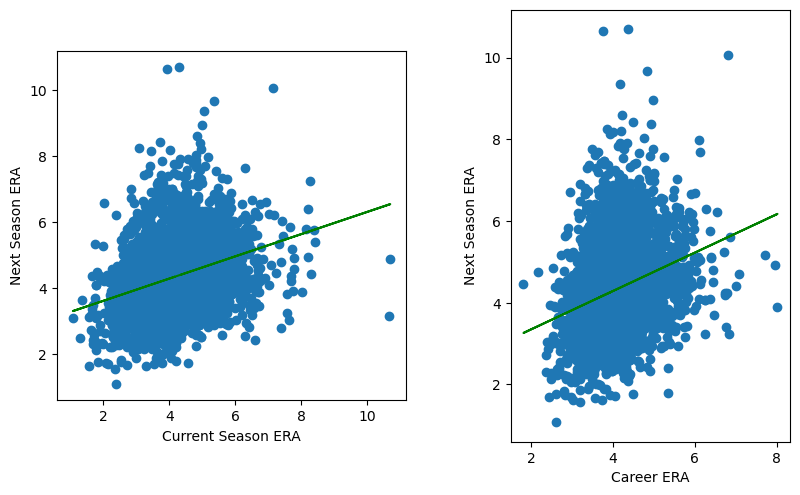

In [154]:
#calculates career ERA. This isn't don't for the training data as doing this for the entire dataset makes the
#program take 20x as long and doesn't affect the accuracy at all
def find_career_era(row, df):
    to_return = df.loc[(df['playerID'] == row['playerID']) & (df['yearID'] <= row['yearID'])]
    return to_return.ER.sum() / to_return.IPouts.sum() * 27
career_stats = recent_data.copy()
career_stats['careerERA'] = career_stats.apply(find_career_era, axis=1, args=(df_stats,))
career_stats = career_stats.drop(career_stats.columns[0:5], axis=1)

#create graphs of next season ERA vs current season ERA and next season ERA vs Career ERA to show correlation
fig, ax = plt.subplots(1, 2)
ax[0].set_aspect('equal')
ax[0].scatter(career_stats.ERA, career_stats.newERA)
b0, m0 = polyfit(career_stats.ERA, career_stats.newERA, 1)
ax[0].plot(recent_data.ERA, b0 + m0 * recent_data.ERA, 'g')
ax[0].set(xlabel='Current Season ERA', ylabel='Next Season ERA')
ax[1].scatter(career_stats.careerERA, career_stats.newERA)
b1, m1 = polyfit(career_stats.careerERA, career_stats.newERA, 1)
ax[1].plot(career_stats.careerERA, b1 + m1 * career_stats.careerERA, 'g')
ax[1].set(xlabel='Career ERA', ylabel='Next Season ERA')
ax[1].set_aspect(1, adjustable='box')
plt.subplots_adjust(left=0.05, right=1.25, bottom=0.05, top=0.95)
plt.show()

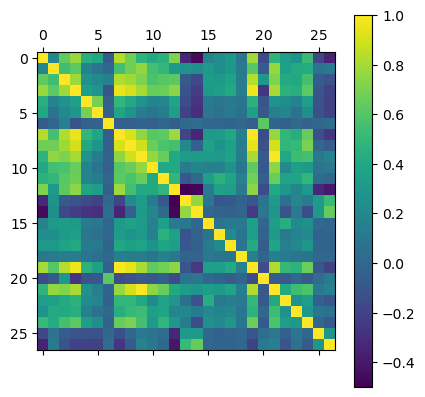

In [142]:
#show visual correlation matrix
fig = plt.matshow(career_stats.corr())
plt.colorbar(fig)
plt.show()

In [143]:
#show correlation matrix with row labels and numerical values
career_stats.corr().style.background_gradient(cmap='coolwarm')

,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,newERA,careerERA
W,1.000000,0.194686,0.635944,0.770622,0.442222,0.394144,-0.060802,0.824201,0.674735,0.473965,0.404462,0.462116,0.711821,-0.324798,-0.464613,0.167950,0.235691,0.297373,0.091873,0.794570,-0.171867,0.476965,0.338876,0.267801,0.514617,-0.181705,-0.351603
L,0.194686,1.000000,0.537199,0.620071,0.169218,0.080440,-0.002929,0.560336,0.674018,0.748590,0.553310,0.495381,0.308027,0.267065,0.243516,0.305964,0.249269,0.302271,0.117036,0.609924,-0.078289,0.759799,0.359621,0.414196,0.420488,0.072268,0.122336
G,0.635944,0.537199,1.000000,0.780673,0.258613,0.212030,0.158299,0.823146,0.788046,0.710911,0.571946,0.610799,0.619461,-0.072848,-0.167345,0.320850,0.314813,0.362588,0.129489,0.835696,0.298998,0.718235,0.417025,0.409398,0.555089,-0.065948,-0.110094
GS,0.770622,0.620071,0.780673,1.000000,0.348024,0.282492,-0.112657,0.954772,0.901793,0.795644,0.651184,0.660934,0.741449,-0.113927,-0.225934,0.311320,0.333415,0.410601,0.136936,0.962197,-0.273827,0.801389,0.463958,0.437053,0.623675,-0.099110,-0.196734
CG,0.442222,0.169218,0.258613,0.348024,1.000000,0.694510,-0.037927,0.490780,0.406407,0.256775,0.173528,0.180176,0.375316,-0.153284,-0.269284,0.116610,0.089430,0.118068,0.085325,0.462758,-0.110724,0.271887,0.230844,0.158754,0.334676,-0.114322,-0.209182
SHO,0.394144,0.080440,0.212030,0.282492,0.694510,1.000000,-0.024207,0.384561,0.273835,0.134389,0.081958,0.133604,0.336882,-0.212355,-0.289773,0.093927,0.062713,0.108163,0.052878,0.352064,-0.086348,0.143450,0.184325,0.065696,0.244505,-0.129449,-0.209124
SV,-0.060802,-0.002929,0.158299,-0.112657,-0.037927,-0.024207,1.000000,-0.051594,-0.043036,-0.022451,-0.039168,0.004032,-0.045407,0.019058,0.034261,-0.002888,-0.012624,-0.018320,0.007193,-0.046614,0.613648,-0.018853,-0.032299,0.013051,-0.028238,0.007970,0.035972
IPouts,0.824201,0.560336,0.823146,0.954772,0.490780,0.384561,-0.051594,1.000000,0.911172,0.750218,0.608943,0.626330,0.777715,-0.184551,-0.337361,0.319693,0.321848,0.394358,0.145990,0.992659,-0.156477,0.760031,0.487181,0.434239,0.653158,-0.135780,-0.265093
H,0.674735,0.674018,0.788046,0.901793,0.406407,0.273835,-0.043036,0.911172,1.000000,0.894083,0.665803,0.573041,0.548845,0.208208,-0.038035,0.357733,0.268531,0.349611,0.132372,0.942217,-0.127486,0.902987,0.488773,0.505300,0.695533,-0.004188,-0.061115
ER,0.473965,0.748590,0.710911,0.795644,0.256775,0.134389,-0.022451,0.750218,0.894083,1.000000,0.761244,0.649527,0.406823,0.330040,0.316664,0.321752,0.306647,0.372829,0.133924,0.811357,-0.083001,0.989334,0.395266,0.528888,0.558746,0.102113,0.167785


In [153]:
#read in csv with names
df_names = pd.read_csv('data/People.csv')
print('To predict Future ERA, please enter the following: ')

#take input and predict ERA for the pitcher input in the year input
while True:
    try:
        #get inputs of first name, last name, and year pitched
        first_name = input('Please enter the pitcher\'s first name: ')
        last_name = input('Please enter the pitcher\'s last name: ')
        year = int(input('Please enter the year to predict: ')) - 1
        #get player ID from first and last name
        player_id = df_names.loc[(df_names.nameFirst == first_name) & (df_names.nameLast == last_name)].playerID.values[0]
        individual_predict = model.predict(df_stats.loc[(df_stats.playerID == player_id) & (df_stats.yearID == year)].drop(df_stats.columns[0:5], axis=1))
        print('The predicted ERA is:', individual_predict[0])
    except ValueError as e:
        print(e)
        print('Please enter a valid number for the year.')
    except:
        print('The name entered does not appear to be in the database for the year entered. Please try again.')
    restart = input('Try again? (y/n): ')
    if restart.lower() == 'n':
        break

To predict Future ERA, please enter the following: 
The predicted ERA is: 3.6315843393760985
